# Relax Inc. Take-Home Challenge

## Introduction
Relax Inc. makes productivity and project management software that's popular with both individuals and teams. Founded by several former Facebook employees, it's considered a great company to work for.

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period , identify which factors predict future user adoption.

## 1. Load the libraries and data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from scipy.stats import randint 

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the data
df = pd.read_csv('takehome_users.csv', encoding='latin-1')
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
df_en = pd.read_csv('takehome_user_engagement.csv')
df_en.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


## 2. Data Wrangling

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [5]:
df_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


### 2.1 Parse to datetime variable

In [6]:
# parse to datetime variables
df['creation_time'] = pd.to_datetime(df['creation_time'])
df_en['time_stamp'] = pd.to_datetime(df_en['time_stamp'])

### 2.2 Handling the missing data

In [7]:
# check the percentage of nan values
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing

object_id                      0.000
creation_time                  0.000
name                           0.000
email                          0.000
creation_source                0.000
last_session_creation_time    26.475
opted_in_to_mailing_list       0.000
enabled_for_marketing_drip     0.000
org_id                         0.000
invited_by_user_id            46.525
dtype: float64

There is big amount of missing data (26.5% on last_session_creation_time and 46.5% on invited_by_user_id). For feature invited_by_user_id, we can just fill in with 0.

In [8]:
# fill in 0 on feature invited_by_user_id
df['invited_by_user_id'] = df['invited_by_user_id'].fillna(0)

In [9]:
df_en.user_id.nunique()

8823

last_session_creation_time is unix timestamp of last login. We also see that each day that there are 8823 unique users in the user logged into the product dataset and it is the same amount of non-missing value. So the missing value here will be the users who didn't login after sign up. So we can fill in the missing value with creation_time.  

In [10]:
# parse the feature last_session_creation_time to datetime
df['last_session_creation_time'] = pd.to_datetime(df['last_session_creation_time'], unit='s')
# fill in missing value with their creation_time
df['last_session_creation_time'] = df['last_session_creation_time'].fillna(df['creation_time'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  12000 non-null  datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


### 2.3 Define adopted user column

In [12]:
df_en.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [13]:
# https://medium.com/@alexander.mueller/rolling-aggregations-on-time-series-data-with-pandas-80dee5893f9
# count the number of visited 
_grouped = df_en.groupby("user_id").rolling(7, on='time_stamp').visited.count()
df_7d_count = pd.DataFrame(_grouped)
df_7d_count = df_7d_count.rename(columns={"visited":"count_7d"})
# merge the results
df_7d_count = df_7d_count.reset_index()
df_result = pd.merge(df_en, df_7d_count, on=['time_stamp', 'user_id'], how='left')
df_result.head()

,time_stamp,user_id,visited,count_7d
0,2014-04-22 03:53:30,1,1,1.0
1,2013-11-15 03:45:04,2,1,1.0
2,2013-11-29 03:45:04,2,1,2.0
3,2013-12-09 03:45:04,2,1,3.0
4,2013-12-25 03:45:04,2,1,4.0


In [14]:
# get the adopted users
adopted = df_result.loc[(df_result['count_7d'] >= 3)]
adopted_user = adopted.user_id.unique()
print("Number of adopted users: {}".format(len(adopted_user)))

Number of adopted users: 2248


In [15]:
df['adopted_user'] = df['object_id'].apply(lambda x: 1 if x in adopted_user else 0)

In [16]:
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0


## 3. Exploratory data analysis

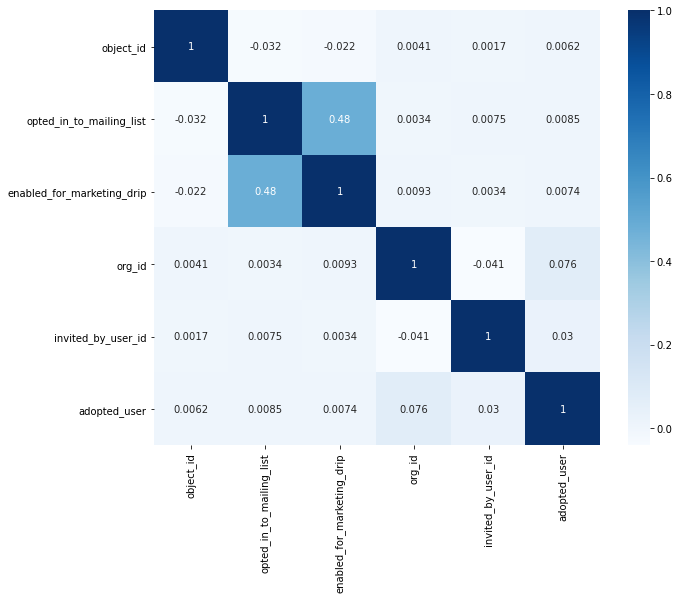

In [17]:
# check the relationships with heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True,cmap ='Blues')

We observe the positive correlation between opted_in_to_mailing_list and enabled_for_marketing_drip, but not strong. I will keep them for now. I will come back if the model overfitting. 

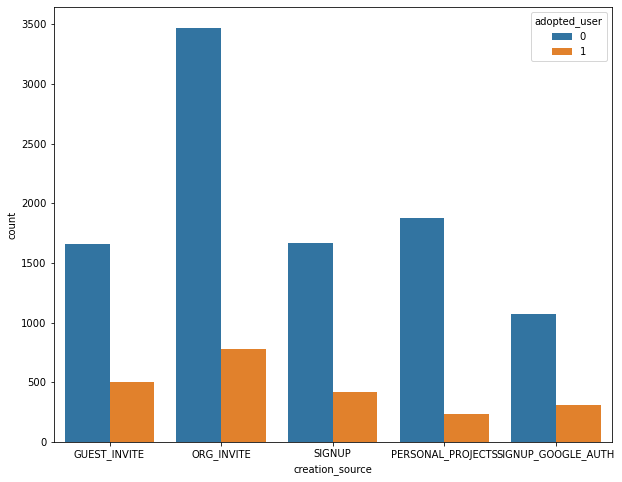

In [18]:
plt.figure(figsize=(10,8))
sns.countplot(x='creation_source', data=df, hue='adopted_user')

We can observe that the percentage of adopted users are different between creation_source. Here, we will use this feature for later model building.

## 4. Pre-processing and Training Data Development

### 4.1 Feature transformation

In [19]:
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0


**Calculate the lasting length of usage from the creation_time and last_session_creation_time for the model building.**

In [20]:
# get the length_usage_day column
df['length_usage_day'] = df['last_session_creation_time'] - df['creation_time']

In [21]:
df.length_usage_day

0         0 days
1       136 days
2         0 days
3         1 days
4         5 days
          ...   
11995     0 days
11996     5 days
11997     0 days
11998     2 days
11999     0 days
Name: length_usage_day, Length: 12000, dtype: timedelta64[ns]

In [22]:
# convert to int
df['length_usage_day'] = df['length_usage_day'].dt.components.days
df.length_usage_day

0          0
1        136
2          0
3          1
4          5
        ... 
11995      0
11996      5
11997      0
11998      2
11999      0
Name: length_usage_day, Length: 12000, dtype: int64

**Email domains**

In [23]:
# extract domain
df['email_domain'] = [x.split('@')[1] for x in df.email] 

In [24]:
df.email_domain.value_counts()[:10]

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
hotmail.com       1165
xvnbr.com            2
mumdc.com            2
oqpze.com            2
dqwln.com            2
Name: email_domain, dtype: int64

In [25]:
# comput top6 email domain and other
df['email_domain'] = [x if x in df.email_domain.value_counts()[:6] else "other" for x in df.email_domain]

In [26]:
df['email_domain'].unique()

array(['yahoo.com', 'gustr.com', 'jourrapide.com', 'hotmail.com',
       'cuvox.de', 'gmail.com', 'other'], dtype=object)

**invited_by_user**

In [27]:
# Let's add a feature to indicate if the user is invited, invited with 1 and uninvited with 0.
df['invited_by_user'] = df['invited_by_user_id'].apply(lambda x: 1 if x > 0 else 0)

### 4.2 Train/test split

In [28]:
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,length_usage_day,email_domain,invited_by_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,0,yahoo.com,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,136,gustr.com,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,0,gustr.com,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,1,yahoo.com,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,5,yahoo.com,1


In [29]:
# features want to use
cols = ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
        'length_usage_day','email_domain', 'invited_by_user']

In [30]:
X = df[cols]

# Make a dependent variable called y with retained column
y = df['adopted_user']

In [31]:
# split features and target into train and test sets
# Call train_test_split on X, y. Make the test_size = 0.25, and random_state = 246
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 246)

In [32]:
# One-hot encode all features in training set.
X_train = pd.get_dummies(X_train, drop_first=True)

# Do the same, but for X_test
X_test = pd.get_dummies(X_test, drop_first=True)

In [33]:
X_train.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,length_usage_day,invited_by_user,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,email_domain_gmail.com,email_domain_gustr.com,email_domain_hotmail.com,email_domain_jourrapide.com,email_domain_other,email_domain_yahoo.com
11777,0,0,264,50,1,1,0,0,0,0,0,0,0,0,1
10097,0,0,24,0,1,1,0,0,0,1,0,0,0,0,0
485,0,0,366,11,0,0,0,1,0,1,0,0,0,0,0
1952,0,0,342,0,0,0,1,0,0,0,0,0,0,0,1
8698,0,0,9,0,0,0,0,1,0,0,0,0,1,0,0


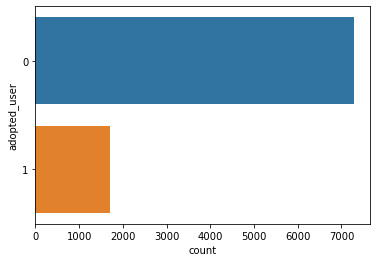

In [34]:
sns.countplot(y=y_train)

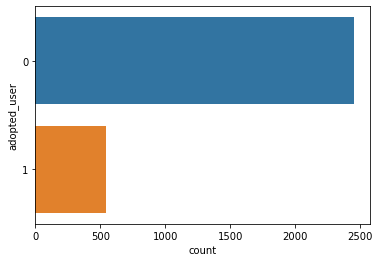

In [35]:
sns.countplot(y=y_test)

Training and tesing sets look good.

## 5. Modeling

### 5.1 Random Search Hyperparameter optimization

In [36]:
param_dist = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(10, 1200, 10, dtype = int)) + [None],
               'max_features': randint(1, 16),
               'min_samples_leaf': randint(1, 11),
               'min_samples_split': randint(2, 20),
               'n_estimators': list(np.linspace(10, 120, 10, dtype = int))}
# Run Randomized Search
rfc = RandomForestClassifier()
model = RandomizedSearchCV(estimator = rfc, param_distributions = param_dist, n_iter = 10, 
                               cv = 4, verbose= 5, random_state= 101, n_jobs = -1)
model.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    8.8s finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

**Print the best score and best parameter**

In [37]:
# Print the best score and best parameter
print("Best Score:" + str(model.best_score_))
print("Best Parameters: " + str(model.best_params_))

Best Score:0.9813333333333333
Best Parameters: {'criterion': 'gini', 'max_depth': 406, 'max_features': 15, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 120}


### 5.2 Model Evaluation

In [38]:
predictionforest = model.best_estimator_.predict(X_test)
print(confusion_matrix(y_test,predictionforest))
print(classification_report(y_test,predictionforest))
acc3 = accuracy_score(y_test,predictionforest)

[[2412   45]
 [  28  515]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2457
           1       0.92      0.95      0.93       543

    accuracy                           0.98      3000
   macro avg       0.95      0.97      0.96      3000
weighted avg       0.98      0.98      0.98      3000



The accuracy in the Random Forest Classifier is 95%.

### 5.3 Plot feature importances

In [39]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=107, 
                             min_samples_leaf=3,
                             min_samples_split=14, 
                             criterion='gini', 
                             max_features=12,
                             max_depth=406)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=406, max_features=12,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=14,
                       min_weight_fraction_leaf=0.0, n_estimators=107,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

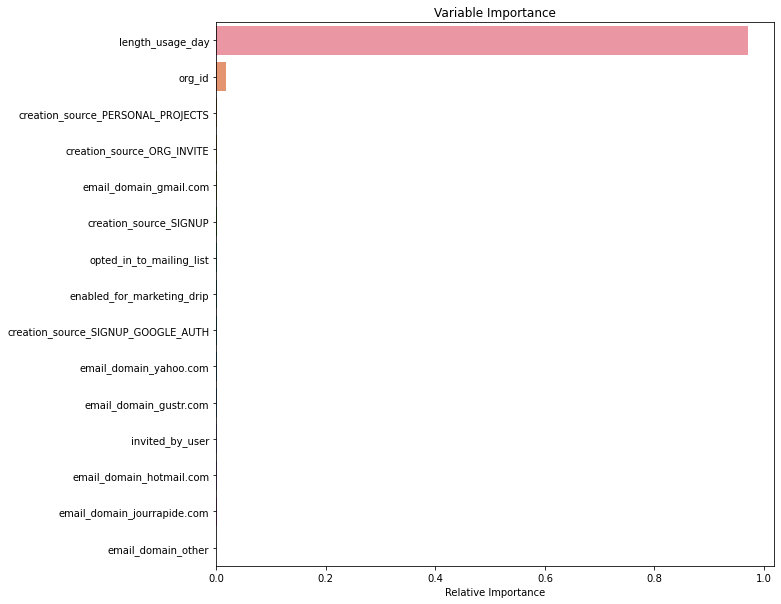

In [40]:
feature_importance = rfc.feature_importances_

df_importances = pd.DataFrame(feature_importance, index=X_train.columns, columns=["Importance"])
df_importances = df_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,10))
sns.barplot(y=df_importances.index, x='Importance', data=df_importances)

plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## 6. Discussion
From the model results, we obtained 95% accuracy. From the feature importance checking, **length_usage_days** and **org_id** are most impontant features.

length_usage_days: the length of usage from the creation_time and last_session_creation_time.

org_id: the organization (group of users) they belong to.